In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
from mlsurfacelayer.derived import air_density
%matplotlib inline
def phi_m_dyer(zeta):
    gamma = 16.0
    karman = 0.4
    beta = 5.0
    epsilon = 1.e-6

    if (zeta < -epsilon):
        phim = 1. / ((1. - gamma * zeta) ** 0.25)
    #
    # Stably stratified case
    elif (zeta > epsilon):
        phim = (1. + beta * zeta)
    #
    # Neutrally stratified case
    elif (zeta >= -epsilon) & (zeta <= epsilon):
        phim = 1.
    return phim

def phi_h_dyer(zeta):
    gamma = 16.0
    karman = 0.4
    beta = 5.0
    epsilon = 1.e-6

    if (zeta < -epsilon):
        phih = 1. / ((1. - gamma * zeta) ** 0.5)
    #
    # Stably stratified case
    elif (zeta > epsilon):
        phih= (1. + beta * zeta)
    #
    # Neutrally stratified case
    elif (zeta >= -epsilon) & (zeta <= epsilon):
        phih = 1.
    return phih

def phi_m_businger(zeta):
    gamma = 15.0
    karman = 0.35
    beta = 4.7
    epsilon = 1.e-6

    if (zeta < -epsilon):
        phim = 1. / ((1. - gamma * zeta) ** 0.25)
    #
    # Stably stratified case
    elif (zeta > epsilon):
        phim = (1. + beta * zeta)
    #
    # Neutrally stratified case
    elif (zeta >= -epsilon) & (zeta <= epsilon):
        phim = 1.
    return phim

def phi_h_businger(zeta):
    gamma = 9.0
    karman = 0.35
    beta = 4.7
    epsilon = 1.e-6

    if (zeta < -epsilon):
        phih = 0.74 * (1 - gamma * zeta) ** -0.5
    #
    # Stably stratified case
    elif (zeta > epsilon):
        phih= (0.74 + beta * zeta)
    #
    # Neutrally stratified case
    elif (zeta >= -epsilon) & (zeta <= epsilon):
        phih = 0.74
    return phih

In [66]:
def obukhov_length(potential_temperature_k, temperature_scale_k, friction_velocity_m_s, von_karman_constant=0.4,
                   min_friction_velocity=0.01, min_temperature_scale=0.01):
    """
    Caclulates the Obukhov length, a measure of stability based on the friction velocity and temperature scale.
    Args:
        potential_temperature_k: The potential temperature in units K
        temperature_scale_k: The turbulent temperature scale (theta*) in units K
        friction_velocity_m_s: The friction velocity (u*) in units m s-1
        von_karman_constant: The von Karman constant (default=0.4)
    Returns:
        The Obukhov length in units m.
    """
    g = 9.81 # m s-2
    #temperature_scale_sign = np.where(temperature_scale_k >= 0, 1, -1)
    #adjusted_temperature_scale_k = temperature_scale_sign * np.maximum(np.abs(temperature_scale_k), min_temperature_scale)
    return friction_velocity_m_s ** 2 * potential_temperature_k / (
            von_karman_constant * g * temperature_scale_k)

In [113]:
def phi_m(friction_velocity, wind_top, wind_bottom, obukhov_length, height_top, height_bottom, diff_min=0.01,
          karman=0.4):
    """
    Calculate the non-dimensional momentum value, which is a ratio of wind speed gradient and friction velocity.
    """
    height_diff = height_top - height_bottom
    #height_mid = 0.5 * (height_top + height_bottom)
    height_mid = np.sqrt(height_top * height_bottom)
    zeta_m = height_bottom / obukhov_length
    wspd_diff = np.maximum(diff_min, wind_top - wind_bottom)
    u_star = np.maximum(diff_min, friction_velocity)
    phi_m =  wspd_diff/ height_diff * karman * height_mid / u_star
    return phi_m, zeta_m

def phi_h(temperature_scale, temp_top, temp_bottom, obukhov_length, height_top, height_bottom, diff_min=0.01,
          karman=0.4):
    """
    Calculate the non-dimensional temperature value, which is a ratio of the temperature gradient and temperature scale.
    
    """
    t_diff = temp_top - temp_bottom
    t_height_diff = height_top - height_bottom
    #t_height_mid = 0.5 * (height_top + height_bottom)
    t_height_mid = np.sqrt(height_top * height_bottom)
    zeta_h = height_bottom / obukhov_length
    t_diff[(t_diff > 0) & (t_diff < diff_min)] = diff_min
    t_diff[(t_diff > -diff_min) & (t_diff < 0)] = -diff_min
    t_scale = np.copy(temperature_scale)
    t_scale[(t_scale > 0) & (t_scale < diff_min)] = diff_min
    t_scale[(t_scale > -diff_min) & (t_scale < 0)] = -diff_min
    phi_h =  t_diff / t_height_diff * karman * t_height_mid / t_scale
    return phi_h, zeta_h

In [96]:
zeta = np.arange(-2, 2.1, 0.01)
phi_m_out = np.zeros((2, zeta.size))
phi_h_out = np.zeros((2, zeta.size))

for i in range(zeta.size):
    phi_m_out[0, i] = phi_m_dyer(zeta[i])
    phi_m_out[1, i] = phi_m_businger(zeta[i])
    phi_h_out[0, i] = phi_h_dyer(zeta[i])
    phi_h_out[1, i] = phi_h_businger(zeta[i])

# Cabauw Phi Values


In [69]:
ml_preds_cabauw = pd.read_csv("/glade/scratch/cbecker/MLSurface_data/cabauw_train_cabauw_test_predictions.csv", index_col="Time")
ml_train_test_cabauw = pd.read_csv("/glade/scratch/cbecker/MLSurface_data/processed_Cabauw_30min_02262003-04122017.csv", index_col="Time")
combined_cabauw = pd.merge(ml_preds_cabauw, ml_train_test_cabauw, how="inner", left_index=True, right_index=True, suffixes=("_pred", "_train"))
combined_cabauw["air_density:2_m:kg_m-3"] = air_density(combined_cabauw["temperature:2_m:K"], combined_cabauw["pressure:2_m:hPa"])
combined_cabauw["air_density_dry:10_m:kg_m-3"] = air_density(combined_cabauw["temperature:10_m:K"], combined_cabauw["pressure:2_m:hPa"])
combined_cabauw["air_density:10_m:kg_m-3"] = air_density(combined_cabauw["virtual_potential_temperature:10_m:K"], combined_cabauw["pressure:2_m:hPa"])
combined_cabauw["temperature_scale_new:surface:K"] = -combined_cabauw["sensible_heat_flux:surface:W_m-2_train"] / (combined_cabauw["air_density_dry:10_m:kg_m-3"] * 287 * 7.0 / 2.0 * combined_cabauw["friction_velocity:surface:m_s-1_pred"])

In [114]:
zeta_new = 0.4 * 9.81 * 4.47 * combined_cabauw["temperature_scale:surface:K_pred"] / (combined_cabauw["temperature:10_m:K"] * combined_cabauw["friction_velocity:surface:m_s-1_pred"] ** 2)
o_length_m = obukhov_length(np.sqrt(combined_cabauw["potential_temperature:20_m:K"] * combined_cabauw["potential_temperature:10_m:K"]), 
                            combined_cabauw["temperature_scale:surface:K_pred"],
                            combined_cabauw["friction_velocity:surface:m_s-1_pred"],
                            min_friction_velocity=0.01, min_temperature_scale=0.01)
combined_cabauw["phi_m_obs"], combined_cabauw["zeta_m_obs"] = phi_m(combined_cabauw["friction_velocity:surface:m_s-1_train"],
                                                                    combined_cabauw["wind_speed:20_m:m_s-1"],
                                                                    combined_cabauw["wind_speed:10_m:m_s-1"],
                                                                    o_length_m,
                                                                    20,
                                                                    10)
combined_cabauw["phi_m_random_forest"], combined_cabauw["zeta_m_random_forest"] = phi_m(combined_cabauw["friction_velocity-random_forest"],
                                                                    combined_cabauw["wind_speed:20_m:m_s-1"],
                                                                    combined_cabauw["wind_speed:10_m:m_s-1"],
                                                                    combined_cabauw["obukhov_length:surface:m"],
                                                                    20,
                                                                    10)
combined_cabauw["phi_m_neural_network"], combined_cabauw["zeta_m_neural_network"] = phi_m(combined_cabauw["friction_velocity-neural_network"],
                                                                    combined_cabauw["wind_speed:20_m:m_s-1"],
                                                                    combined_cabauw["wind_speed:10_m:m_s-1"],
                                                                    combined_cabauw["obukhov_length:surface:m"],
                                                                    20,
                                                                    10)
o_length_h = obukhov_length(np.sqrt(combined_cabauw["potential_temperature:10_m:K"] * combined_cabauw["potential_temperature:2_m:K"]), 
                            combined_cabauw["temperature_scale_new:surface:K"],
                            combined_cabauw["friction_velocity:surface:m_s-1_pred"],
                            min_friction_velocity=0.01, min_temperature_scale=0.01)
combined_cabauw["phi_h_obs"], combined_cabauw["zeta_h_obs"] = phi_h(combined_cabauw["temperature_scale:surface:K_pred"],
                                                                    combined_cabauw["temperature:10_m:K"],
                                                                    combined_cabauw["temperature:2_m:K"],
                                                                    o_length_h,
                                                                    10,
                                                                    2,
                                                                    diff_min=0.1)
o_length_h_rf = obukhov_length(combined_cabauw["potential_temperature:10_m:K"], 
                            combined_cabauw["temperature_scale-random_forest"],
                            combined_cabauw["friction_velocity-random_forest"],
                            min_friction_velocity=0.001, min_temperature_scale=0.001)
combined_cabauw["phi_h_random_forest"], combined_cabauw["zeta_h_random_forest"] = phi_h(combined_cabauw["temperature_scale-random_forest"],
                                                                    combined_cabauw["potential_temperature:10_m:K"],
                                                                    combined_cabauw["potential_temperature:2_m:K"],
                                                                    o_length_h_rf,
                                                                    10,
                                                                    2, diff_min=0.01)
o_length_h_nn = obukhov_length(combined_cabauw["potential_temperature:10_m:K"], 
                            combined_cabauw["temperature_scale-neural_network"],
                            combined_cabauw["friction_velocity-neural_network"],
                           min_friction_velocity=0.1, min_temperature_scale=0.1)
combined_cabauw["phi_h_neural_network"], combined_cabauw["zeta_h_neural_network"] = phi_h(combined_cabauw["temperature_scale-neural_network"],
                                                                    combined_cabauw["potential_temperature:10_m:K"],
                                                                    combined_cabauw["potential_temperature:2_m:K"],
                                                                    o_length_h_nn,
                                                                    10,
                                                                    2, diff_min=0.01)


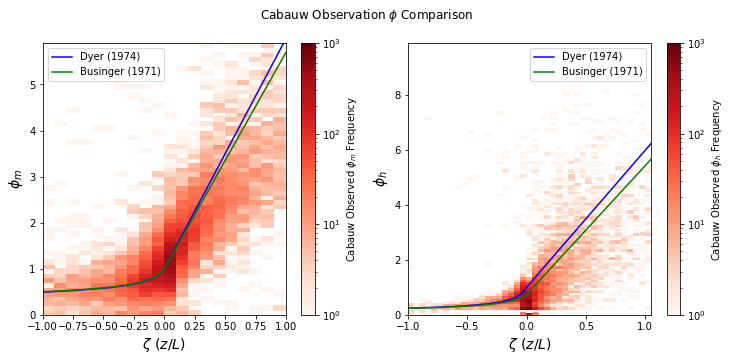

In [117]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_m_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_cabauw["zeta_m_obs"], combined_cabauw["phi_m_obs"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Cabauw Observed $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")
plt.hist2d(combined_cabauw["zeta_h_obs"], combined_cabauw["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.05), np.arange(0, 10, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Cabauw Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)
plt.suptitle("Cabauw Observation $\phi$ Comparison")

plt.legend(loc=0)
plt.savefig("cabauw_phi_comparison.png", dpi=250, bbox_inches="tight")

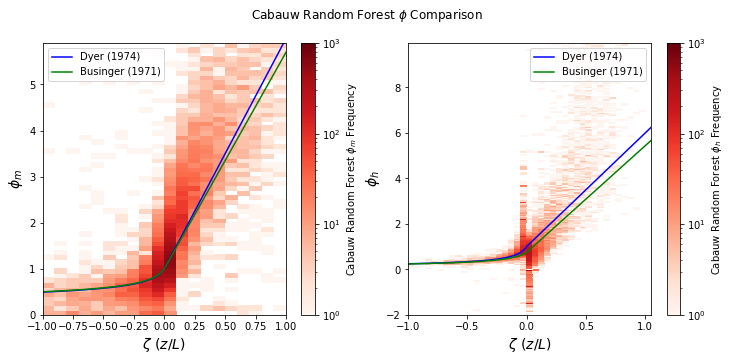

In [118]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_m_out[1], color="green", label="Businger (1971)")

plt.hist2d(zeta_new, combined_cabauw["phi_m_random_forest"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Cabauw Random Forest $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_cabauw["zeta_h_random_forest"], combined_cabauw["phi_h_random_forest"], 
           bins=(np.arange(-1, 1.1, 0.05), np.arange(-2, 10, 0.05)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Cabauw Random Forest $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)

plt.legend(loc=0)
plt.suptitle("Cabauw Random Forest $\phi$ Comparison")

plt.savefig("cabauw_phi_comparison_rf.png", dpi=250, bbox_inches="tight")

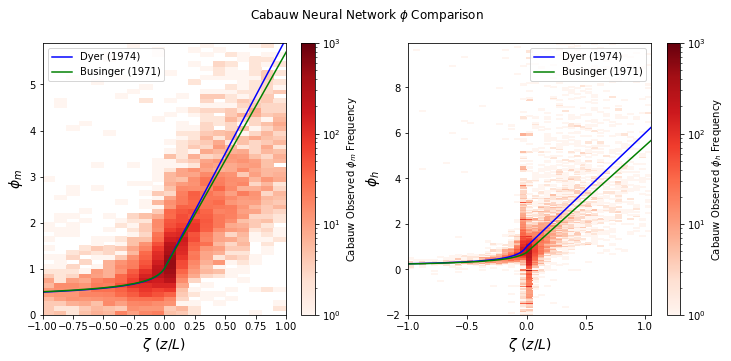

In [119]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_m_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_cabauw["zeta_m_obs"], combined_cabauw["phi_m_neural_network"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Cabauw Observed $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_cabauw["zeta_h_obs"], combined_cabauw["phi_h_neural_network"], 
           bins=(np.arange(-1, 1.1, 0.05), np.arange(-2, 10, 0.05)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Cabauw Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)
plt.suptitle("Cabauw Neural Network $\phi$ Comparison")

plt.legend(loc=0)
plt.savefig("cabauw_phi_comparison_nn.png", dpi=250, bbox_inches="tight")

In [137]:
ml_preds_idaho = pd.read_csv("/glade/scratch/cbecker/MLSurface_data/idaho_train_idaho_test_predictions.csv", index_col="Time")
ml_train_test_idaho = pd.read_csv("/glade/scratch/cbecker/MLSurface_data/processed_Idaho_30min_03012015-12312017.csv", index_col="Time")
combined_idaho = pd.merge(ml_train_test_idaho, ml_preds_idaho, how="left", left_index=True, right_index=True, suffixes=("_pred", "_train"))
combined_idaho["temperature_scale_new:surface:K_train"] = -combined_idaho["sensible_heat_flux:surface:W_m-2_train"] / (combined_idaho["air_density:10_m:kg_m-3_train"] * 287 * 7.0 / 2.0 * combined_idaho["friction_velocity:surface:m_s-1_train"])

In [ ]:
combined_idaho["obukhov_length:0_m:m"]

<AxesSubplot:>

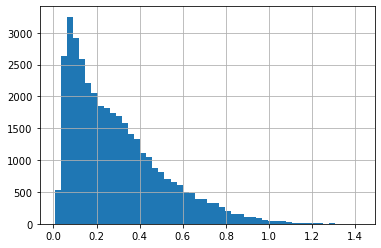

In [36]:
ml_train_test_idaho["friction_velocity:surface:m_s-1"].hist(bins=50)


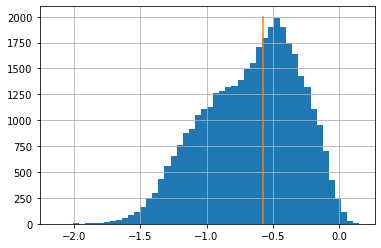

In [40]:
np.log10(ml_train_test_idaho["friction_velocity:surface:m_s-1"]).hist(bins=50)
plt.plot([np.log10(0.265)] * 10, np.linspace(0, 2000, 10))

<AxesSubplot:>

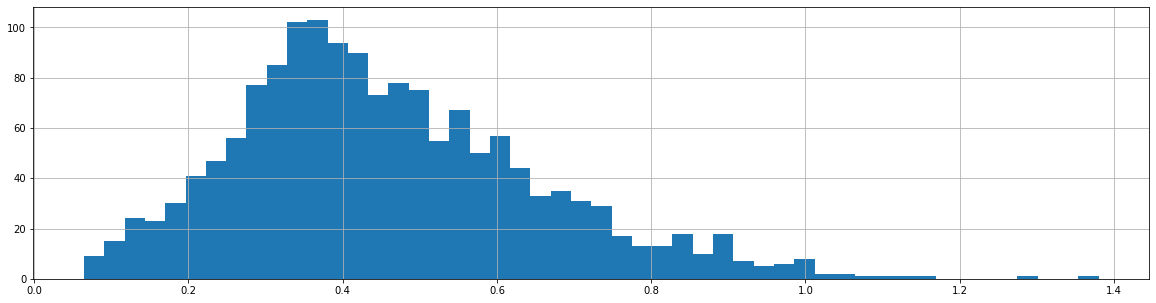

In [56]:
plt.figure(figsize=(20, 5))
maxes = ml_train_test_idaho["friction_velocity:surface:m_s-1"].rolling(window=24).max()[::24]
mins = ml_train_test_idaho["friction_velocity:surface:m_s-1"].rolling(window=24).min()[::24]
(maxes-mins).hist(bins=50)

In [135]:
ml_train_test_idaho

,wind_speed:2_m:m_s-1,wind_gust:2_m:m_s-1,wind_direction:2_m:degrees,sigma_theta:2_m:degrees,wind_speed:10_m:m_s-1,wind_gust:10_m:m_s-1,wind_direction:10_m:degrees,sigma_theta:10_m:degrees,wind_speed:15_m:m_s-1,wind_gust:15_m:m_s-1,...,skin_potential_temperature:0_m:K,skin_saturation_mixing_ratio:0_m:g_kg-1,bulk_richardson:10_m:None,potential_temperature_skin_change:2_m:K_m-1,potential_temperature_skin_change:10_m:K_m-1,potential_temperature_skin_change:15_m:K_m-1,potential_temperature_skin_change:45_m:K_m-1,virtual_potential_temperature_skin_change:2_m:K_m-1,mixing_ratio_skin_change:2_m:g_kg-1_m-1,moisture_availability:soil:None
Time,,,,,,,,,,,,,,,,,,,,,
2015-03-01 09:00:00,5.1,6.6,52.5,10.4,6.8,8.1,48.4,6.0,7.0,8.2,...,115.119750,7.374621e-13,1.247817,-82.345844,-16.394873,-10.919451,-3.628888,-3.664043,-0.024771,0.019765
2015-03-01 09:30:00,4.3,5.6,43.3,11.1,5.6,7.2,39.0,7.2,5.7,7.0,...,144.248216,1.554596e-08,1.518391,-68.343944,-13.569385,-9.042071,-3.003095,-3.041682,-0.024354,0.021795
2015-03-01 10:00:00,4.4,6.1,47.9,14.1,5.4,6.9,43.8,11.3,5.5,6.6,...,166.017783,2.701907e-06,1.377592,-57.905459,-11.479594,-7.643994,-2.533581,-2.577889,-0.025087,0.021795
2015-03-01 10:30:00,4.4,6.3,43.9,12.4,5.7,7.8,38.1,9.5,5.8,7.5,...,176.770616,2.158052e-05,1.127046,-53.063873,-10.497669,-6.990772,-2.318166,-2.362655,-0.024689,0.022503
2015-03-01 11:00:00,4.1,5.7,55.7,15.9,5.1,7.1,48.1,13.3,5.2,6.9,...,186.724377,1.192151e-04,1.285666,-48.736586,-9.629063,-6.412399,-2.123978,-2.170157,-0.023567,0.024724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 18:00:00,0.7,0.7,344.9,3.2,1.8,1.9,7.5,2.2,1.9,2.0,...,274.167420,1.981027e+00,0.360441,-0.432767,-0.298728,-0.208211,-0.071726,-0.026117,0.002999,0.010295
2017-12-31 18:30:00,0.8,0.8,123.1,15.4,1.5,1.7,80.1,2.3,1.5,1.7,...,272.917088,1.800784e+00,0.719055,-1.301440,-0.425433,-0.294074,-0.114284,-0.064840,-0.001622,0.010295
2017-12-31 19:00:00,0.6,0.9,322.3,7.7,1.0,1.2,65.0,4.7,1.4,1.6,...,272.292790,1.715803e+00,1.300657,-1.106082,-0.336194,-0.238066,-0.118843,-0.055639,-0.000569,0.010295


<AxesSubplot:>

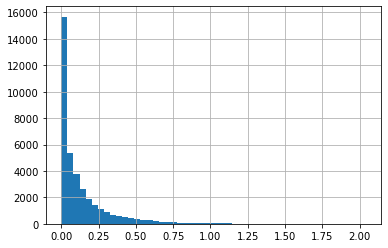

In [27]:
ml_train_test_idaho["Tau:surface:kg_m-1_s-2"].hist(bins=50)


<AxesSubplot:>

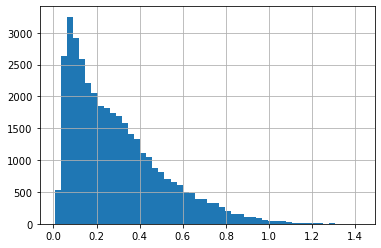

In [23]:
ml_train_test_idaho["friction_velocity:surface:m_s-1"].hist(bins=50)

<AxesSubplot:>

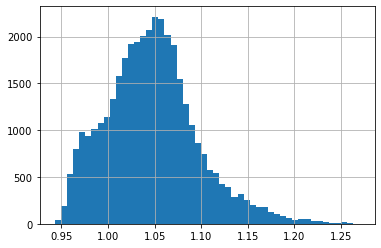

In [28]:
ml_train_test_idaho["air_density:10_m:kg_m-3"].hist(bins=50)

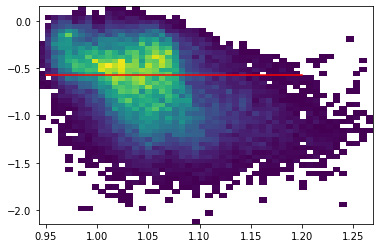

In [34]:
plt.hist2d(ml_train_test_idaho["air_density:10_m:kg_m-3"], np.log10(ml_train_test_idaho["friction_velocity:surface:m_s-1"]), cmin=1, bins=50)
plt.plot(np.linspace(0.95, 1.2, 10), np.ones(10) * np.log10(0.265), color='r')

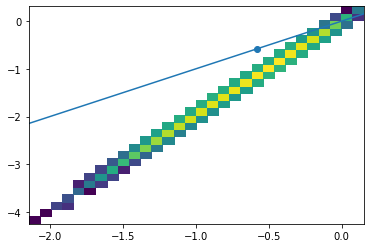

In [20]:
plt.hist2d(np.log10(ml_train_test_idaho["friction_velocity:surface:m_s-1"]), np.log10(ml_train_test_idaho["Tau:surface:kg_m-1_s-2"]), 
           bins=30, cmin=1, norm=LogNorm())
plt.scatter([np.log10(0.265)], [np.log10(0.265)])
plt.plot(np.arange(-4, 1, 0.1), np.arange(-4, 1, 0.1))

In [157]:
zeta_new_i = 0.4 * 9.81 * 4.47 * combined_idaho["temperature_scale_new:surface:K_train"] / (combined_idaho["potential_temperature:10_m:K"] * combined_idaho["friction_velocity:surface:m_s-1_train"] ** 2)
o_length_m = obukhov_length(np.sqrt(combined_idaho["potential_temperature:15_m:K"] * combined_idaho["potential_temperature:10_m:K"]), 
                            combined_idaho["temperature_scale:surface:K_train"],
                            combined_idaho["friction_velocity:surface:m_s-1_train"],
                            min_friction_velocity=0.01, min_temperature_scale=0.01)
combined_idaho["phi_m_obs"], combined_idaho["zeta_m_obs"] = phi_m(combined_idaho["friction_velocity:surface:m_s-1_train"],
                                                                    combined_idaho["wind_speed:15_m:m_s-1"],
                                                                    combined_idaho["wind_speed:10_m:m_s-1"],
                                                                    o_length_m,
                                                                    15,
                                                                    10)
combined_idaho["phi_m_random_forest"], combined_idaho["zeta_m_random_forest"] = phi_m(combined_idaho["friction_velocity-random_forest"],
                                                                    combined_idaho["wind_speed:15_m:m_s-1"],
                                                                    combined_idaho["wind_speed:10_m:m_s-1"],
                                                                    combined_idaho["obukhov_length:0_m:m"],
                                                                    15,
                                                                    10)
combined_idaho["phi_m_neural_network"], combined_idaho["zeta_m_neural_network"] = phi_m(combined_idaho["friction_velocity-neural_network"],
                                                                    combined_idaho["wind_speed:15_m:m_s-1"],
                                                                    combined_idaho["wind_speed:10_m:m_s-1"],
                                                                    combined_idaho["obukhov_length:0_m:m"],
                                                                    15,
                                                                    10)

o_length_h = obukhov_length(np.sqrt(combined_idaho["potential_temperature:10_m:K"] * combined_idaho["potential_temperature:2_m:K"]), 
                            combined_idaho["temperature_scale:surface:K_train"],
                            combined_idaho["friction_velocity:surface:m_s-1_pred"])
combined_idaho["phi_h_obs"], combined_idaho["zeta_h_obs"] = phi_h(combined_idaho["temperature_scale:surface:K_pred"],
                                                                    combined_idaho["potential_temperature:10_m:K"],
                                                                    combined_idaho["potential_temperature:2_m:K"],
                                                                    o_length_h,
                                                                    10,
                                                                    2, diff_min=0.01)


o_length_h = obukhov_length(combined_idaho["potential_temperature:10_m:K"], 
                            combined_idaho["temperature_scale-random_forest"],
                            combined_idaho["friction_velocity-random_forest"],
                           min_friction_velocity=0.1, min_temperature_scale=0.1)
combined_idaho["phi_h_random_forest"], combined_idaho["zeta_h_random_forest"] = phi_h(combined_idaho["temperature_scale-random_forest"],
                                                                    combined_idaho["potential_temperature:10_m:K"],
                                                                    combined_idaho["potential_temperature:2_m:K"],
                                                                    o_length_h,
                                                                    10,
                                                                    2)
o_length_h = obukhov_length(combined_idaho["potential_temperature:10_m:K"], 
                            combined_idaho["temperature_scale-neural_network"],
                            combined_idaho["friction_velocity-neural_network"],
                           min_friction_velocity=0.1, min_temperature_scale=0.1)
combined_idaho["phi_h_neural_network"], combined_idaho["zeta_h_neural_network"] = phi_h(combined_idaho["temperature_scale-neural_network"],
                                                                    combined_idaho["potential_temperature:10_m:K"],
                                                                    combined_idaho["potential_temperature:2_m:K"],
                                                                    o_length_h,
                                                                    10,
                                                                    2)


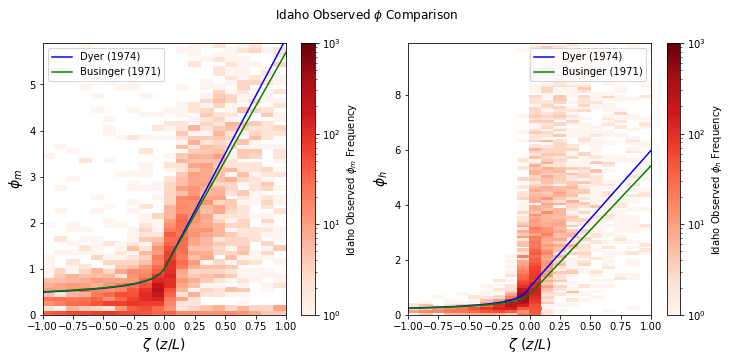

In [171]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_m_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_m_obs"], combined_idaho["phi_m_obs"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Idaho Observed $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_h_obs"], combined_idaho["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 10, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Idaho Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)
plt.suptitle("Idaho Observed $\phi$ Comparison")

plt.legend(loc=0)
plt.savefig("idaho_phi_comparison.png", dpi=250, bbox_inches="tight")

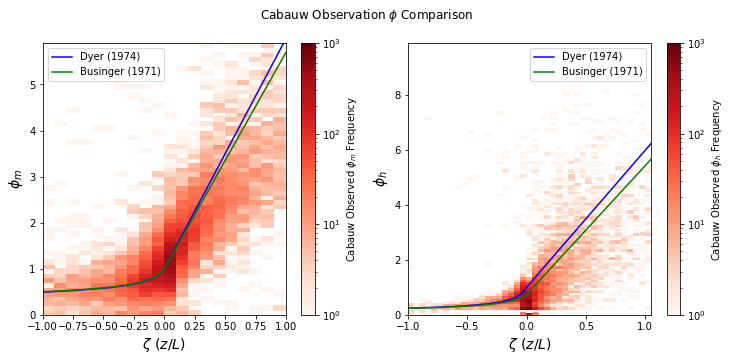

In [117]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_m_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_cabauw["zeta_m_obs"], combined_cabauw["phi_m_obs"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Cabauw Observed $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")
plt.hist2d(combined_cabauw["zeta_h_obs"], combined_cabauw["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.05), np.arange(0, 10, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Cabauw Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)
plt.legend(loc=0)

plt.savefig("cabauw_phi_comparison.png", dpi=250, bbox_inches="tight")

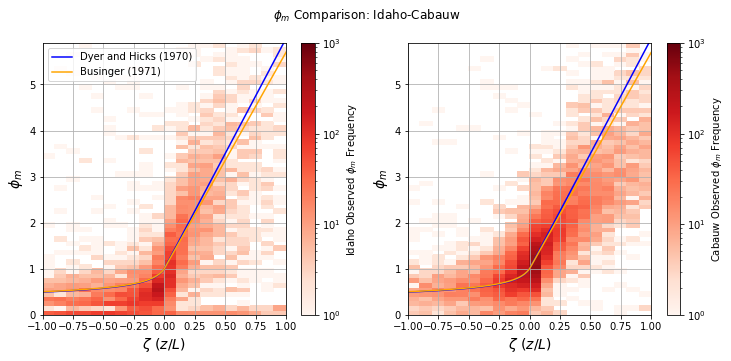

In [220]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer and Hicks (1970)")
plt.plot(zeta, phi_m_out[1], color="orange", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_m_obs"], combined_idaho["phi_m_obs"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Idaho Observed $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)
plt.grid()
plt.legend(loc=0)
plt.subplot(1, 2, 2)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer and Hicks (1970)")
plt.plot(zeta, phi_m_out[1], color="orange", label="Businger (1971)")

plt.hist2d(combined_cabauw["zeta_m_obs"], combined_cabauw["phi_m_obs"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Cabauw Observed $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)
#plt.legend(loc=0)
plt.suptitle("$\phi_m$ Comparison: Idaho-Cabauw")
plt.grid()
plt.savefig("phi_m_comparison.png", dpi=250, bbox_inches="tight")

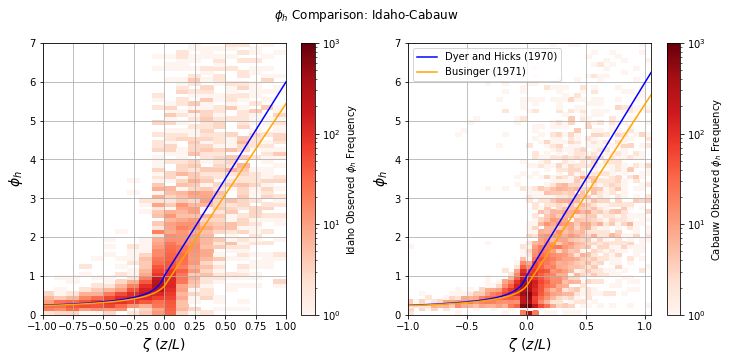

In [221]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer and Hicks (1970)")
plt.plot(zeta, phi_h_out[1], color="orange", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_h_obs"] * 6 / 2, combined_idaho["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 7.1, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Idaho Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)
plt.grid()

#plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer and Hicks (1970)")
plt.plot(zeta, phi_h_out[1], color="orange", label="Businger (1971)")
plt.hist2d(combined_cabauw["zeta_h_obs"] * 2 / 2, combined_cabauw["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.05), np.arange(0, 7.1, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Cabauw Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)
plt.legend(loc=0)
plt.suptitle("$\phi_h$ Comparison: Idaho-Cabauw")
plt.grid()
plt.savefig("phi_h_comparison_6_2.png", dpi=250, bbox_inches="tight")

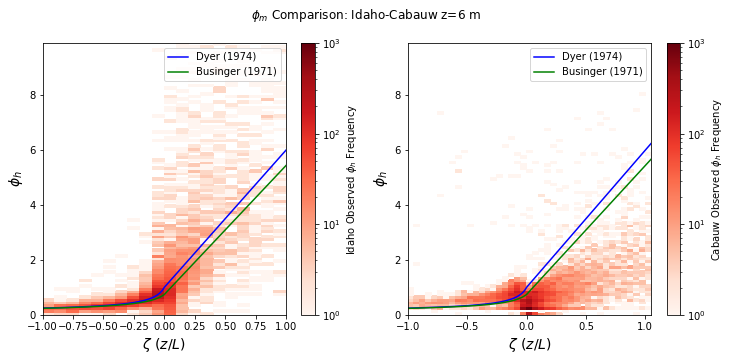

In [205]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_h_obs"] * 6 / 2, combined_idaho["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 10, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Idaho Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")
plt.hist2d(combined_cabauw["zeta_h_obs"] * 6 / 2, combined_cabauw["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.05), np.arange(0, 10, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Cabauw Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)
plt.legend(loc=0)
plt.suptitle("$\phi_m$ Comparison: Idaho-Cabauw z=6 m")

plt.savefig("phi_h_comparison_6.png", dpi=250, bbox_inches="tight")

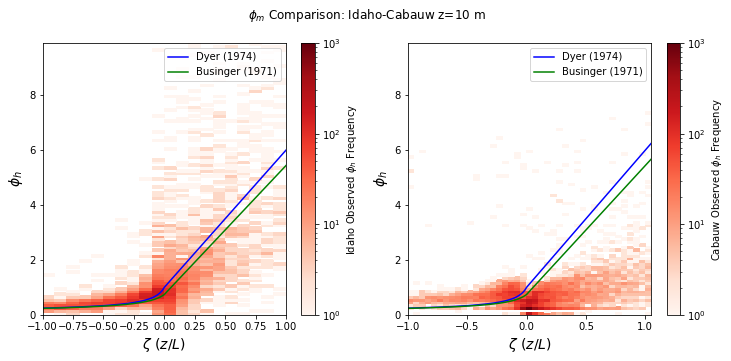

In [204]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_h_obs"] * 10 / 2, combined_idaho["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 10, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Idaho Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")
plt.hist2d(combined_cabauw["zeta_h_obs"] * 10 / 2, combined_cabauw["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.05), np.arange(0, 10, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Cabauw Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)
plt.legend(loc=0)
plt.suptitle("$\phi_m$ Comparison: Idaho-Cabauw z=10 m")

plt.savefig("phi_h_comparison_10.png", dpi=250, bbox_inches="tight")

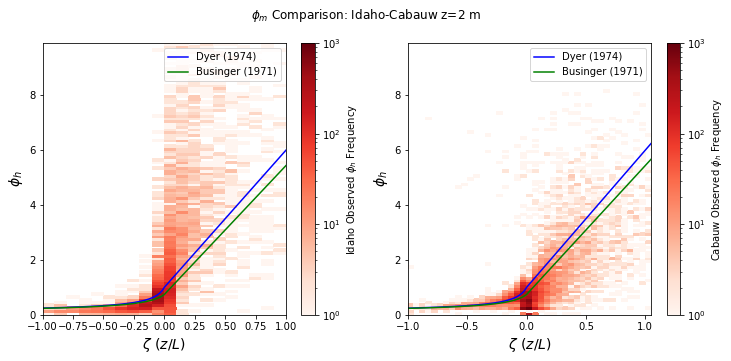

In [203]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_h_obs"], combined_idaho["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 10, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Idaho Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")
plt.hist2d(combined_cabauw["zeta_h_obs"], combined_cabauw["phi_h_obs"], 
           bins=(np.arange(-1, 1.1, 0.05), np.arange(0, 10, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Cabauw Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)
plt.legend(loc=0)
plt.suptitle("$\phi_m$ Comparison: Idaho-Cabauw z=2 m")

plt.savefig("phi_h_comparison_2.png", dpi=250, bbox_inches="tight")

<AxesSubplot:xlabel='Time'>

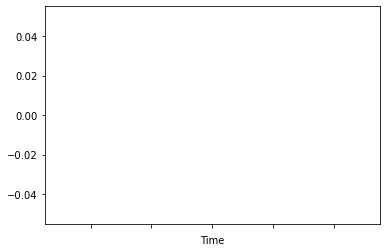

In [130]:
combined_idaho.loc["2016-03-01":"2016-03-05", "friction_velocity:surface:m_s-1_pred"].plot()

In [133]:
combined_idaho

,friction_velocity-random_forest,friction_velocity-neural_network,friction_velocity-mo,temperature_scale-random_forest,temperature_scale-neural_network,temperature_scale-mo,moisture_scale-random_forest,moisture_scale-neural_network,moisture_scale-mo,sensible_heat_flux:surface:W_m-2_pred,...,phi_m_random_forest,zeta_m_random_forest,phi_m_neural_network,zeta_m_neural_network,phi_h_obs,zeta_h_obs,phi_h_random_forest,zeta_h_random_forest,phi_h_neural_network,zeta_h_neural_network
Time,,,,,,,,,,,,,,,,,,,,,
2015-03-01 09:00:00,0.429171,0.004532,0.239076,-0.154184,1.600194,3.699033,0.015191,0.054991,-0.000497,76.969640,...,0.456599,-0.112352,19.595918,-0.112352,1.057300,-0.022530,1.077475,-0.023541,-0.103819,2191.434079
2015-03-01 09:30:00,0.384888,0.004273,0.196886,-0.231503,1.460205,3.062221,0.018278,0.049446,-0.000538,120.745250,...,0.254566,-0.167181,9.797959,-0.167181,0.913592,-0.033555,0.960134,-0.043810,-0.152221,2241.694443
2015-03-01 10:00:00,0.388676,0.009626,0.189855,-0.249688,1.337918,2.591405,0.020004,0.043368,-0.000554,134.462070,...,0.252086,-0.257852,9.797959,-0.257852,0.748802,-0.051757,0.908956,-0.046192,-0.169634,403.541315
2015-03-01 10:30:00,0.396212,0.019703,0.200402,-0.256254,1.243139,2.370063,0.025690,0.042959,-0.000563,179.738430,...,0.247291,-0.314070,4.972830,-0.314070,0.653566,-0.063071,1.004411,-0.045469,-0.207044,89.197982
2015-03-01 11:00:00,0.380206,0.016430,0.179307,-0.311771,1.145948,2.174137,0.030416,0.044567,-0.000591,207.473800,...,0.257701,-0.397444,5.963434,-0.397444,0.562400,-0.079821,0.848137,-0.059806,-0.230747,117.716181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-20 14:00:00,0.157962,0.163536,0.088457,-0.292310,-0.358794,-0.135948,0.128744,0.103868,0.007268,46.931217,...,0.062027,-0.804571,0.059913,-0.804571,0.292243,-0.161078,0.232168,-0.308478,0.189148,-0.353269
2015-10-20 14:30:00,0.162017,0.160330,0.088457,-0.319115,-0.375419,-0.140659,0.147025,0.113754,0.008162,45.761430,...,0.060475,-3.552980,0.061111,-3.552980,0.199627,-0.711393,0.234667,-0.319659,0.199472,-0.384016
2015-10-20 15:00:00,0.255572,0.221252,0.172564,-0.224489,-0.227562,-0.099026,0.079811,0.078258,0.008451,37.490063,...,0.383374,-0.164846,0.442842,-0.164846,0.850346,-0.033019,0.448241,-0.090149,0.442189,-0.121932


<AxesSubplot:>

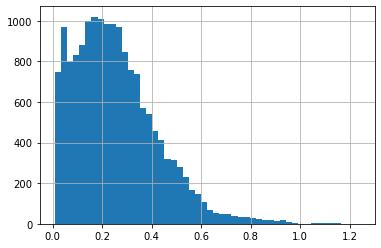

In [125]:
combined_cabauw["friction_velocity:surface:m_s-1_pred"].hist(bins=50)

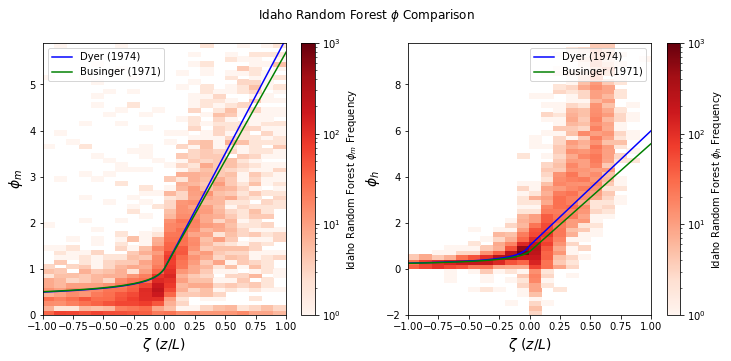

In [85]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_m_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_m_random_forest"], combined_idaho["phi_m_random_forest"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Idaho Random Forest $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_h_random_forest"], combined_idaho["phi_h_random_forest"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(-2, 10, 0.2)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Idaho Random Forest $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)

plt.legend(loc=0)
plt.suptitle("Idaho Random Forest $\phi$ Comparison")

plt.savefig("idaho_phi_comparison_rf.png", dpi=250, bbox_inches="tight")

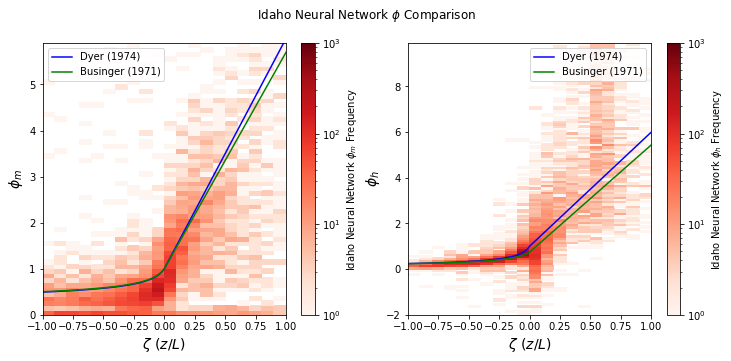

In [86]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_m_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_m_neural_network"], combined_idaho["phi_m_neural_network"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Idaho Neural Network $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_idaho["zeta_h_neural_network"], combined_idaho["phi_h_neural_network"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(-2, 10, 0.1)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Idaho Neural Network $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)

plt.legend(loc=0)
plt.suptitle("Idaho Neural Network $\phi$ Comparison")
plt.savefig("idaho_phi_comparison_nn.png", dpi=250, bbox_inches="tight")

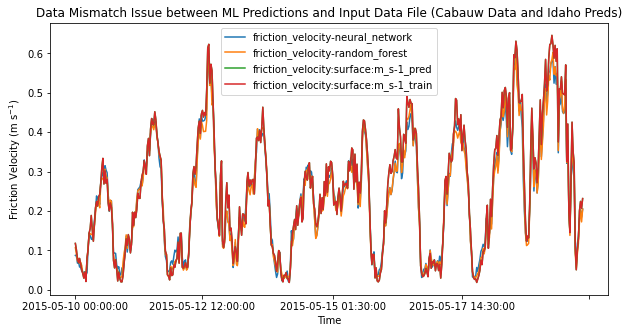

In [112]:
start_date = "2015-05-10"
end_date = "2015-05-20"
fig, ax = plt.subplots(figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
combined_preds["friction_velocity-neural_network"].loc[start_date:end_date].plot()
combined_preds["friction_velocity-random_forest"].loc[start_date:end_date].plot()
combined_preds["friction_velocity:surface:m_s-1_pred"].loc[start_date:end_date].plot()
combined_preds["friction_velocity:surface:m_s-1_train"].loc[start_date:end_date].plot()
plt.legend()
plt.ylabel("Friction Velocity (m s$^{-1}$)")
plt.title("Data Mismatch Issue between ML Predictions and Input Data File (Cabauw Data and Idaho Preds)")
plt.savefig("fv_ts_issue_w_idaho_preds.png", dpi=250, bbox_inches="tight")

In [115]:
combined_preds["zeta_m"] = 15.0 / combined_preds["obukhov_length:surface:m"]
combined_preds["zeta_h"] = 6.0 / combined_preds["obukhov_length:surface:m"]
wspd_20_m = np.maximum(0.1, combined_preds["wind_speed:20_m:m_s-1"])
wspd_10_m = np.maximum(0.1, combined_preds["wind_speed:10_m:m_s-1"])
combined_preds["phi_m_random-forest"] =  wspd_diff / m_height_diff * 0.4 * m_height_mid / np.maximum(0.1, combined_preds["friction_velocity-random_forest"])

In [104]:
ml_preds_cabauw.columns

Index(['friction_velocity-random_forest', 'friction_velocity-neural_network',
       'friction_velocity-mo', 'temperature_scale-random_forest',
       'temperature_scale-neural_network', 'temperature_scale-mo',
       'moisture_scale-random_forest', 'moisture_scale-neural_network',
       'moisture_scale-mo', 'sensible_heat_flux:surface:W_m-2',
       'latent_heat_flux:surface:W_m-2', 'bulk_richardson:10_m:None',
       'air_density:10_m:kg_m-3', 'friction_velocity:surface:m_s-1',
       'moisture_scale:surface:g_kg-1', 'temperature_scale:surface:K'],
      dtype='object')

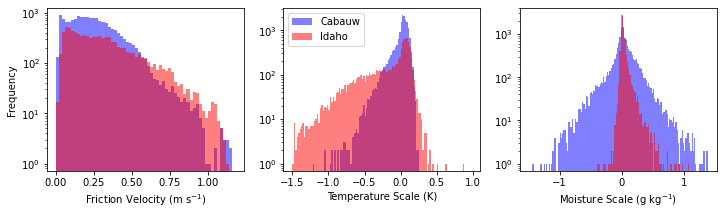

In [257]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
ustar_bins = np.arange(0, 1.2, 0.02)
plt.hist(combined_cabauw["friction_velocity:surface:m_s-1_train"],bins=ustar_bins, facecolor="blue", alpha=0.5)
plt.hist(combined_idaho["friction_velocity:surface:m_s-1_train"],bins=ustar_bins, facecolor="red", alpha=0.5)
plt.xlabel("Friction Velocity (m s$^{-1}$)")
plt.gca().set_yscale("log")
plt.ylabel("Frequency")
plt.subplot(1, 3, 2)
tstar_bins = np.arange(-1.5, 1, 0.02)
plt.hist(combined_cabauw["temperature_scale:surface:K_train"],bins=tstar_bins, facecolor="blue", alpha=0.5, label="Cabauw")
plt.hist(combined_idaho["temperature_scale:surface:K_train"],bins=tstar_bins, facecolor="red", alpha=0.5, label="Idaho")
plt.legend(loc=0)
plt.xlabel("Temperature Scale (K)")

plt.gca().set_yscale("log")
plt.subplot(1, 3, 3)
qstar_bins = np.arange(-1.5, 1.4, 0.02)
plt.hist(combined_cabauw["moisture_scale:surface:g_kg-1_train"],bins=qstar_bins, facecolor="blue", alpha=0.5)
plt.hist(combined_idaho["moisture_scale:surface:g_kg-1_train"],bins=qstar_bins, facecolor="red", alpha=0.5)
plt.xlabel("Moisture Scale (g kg$^{-1}$)")
plt.gca().set_yscale("log")
plt.savefig("scale_hist.png", dpi=300, bbox_inches="tight")

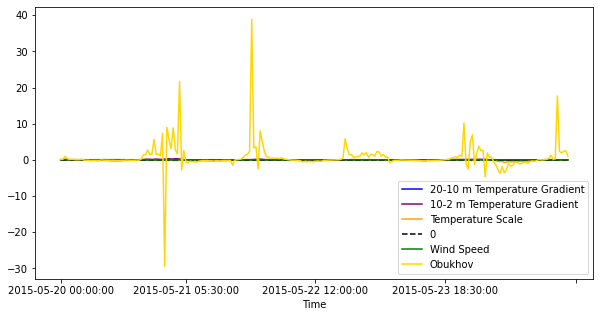

In [129]:
##### t_diff = combined_cabauw["virtual_potential_temperature:20_m:K"] - combined_cabauw["virtual_potential_temperature:10_m:K"]
t_diff_2 = combined_cabauw["virtual_potential_temperature:10_m:K"] - combined_cabauw["virtual_potential_temperature:2_m:K"]
fix, ax = plt.subplots(figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
#ph = combined_cabauw.loc["2015-05-20":"2015-05-22", "phi_h_obs"] * 0.1
#ph.plot()
#t_diff.loc["2015-05-20":"2015-05-22"].plot()
(t_diff.loc["2015-05-20":"2015-05-25"] / 10).plot(color="blue", label="20-10 m Temperature Gradient")
(t_diff_2.loc["2015-05-20":"2015-05-25"] / 8).plot(color="purple", label="10-2 m Temperature Gradient")
combined_cabauw.loc["2015-05-20":"2015-05-25", "temperature_scale:surface:K_pred"].plot(color='orange', label="Temperature Scale")
(combined_cabauw.loc["2015-05-20":"2015-05-25", "temperature_scale:surface:K_pred"] * 0).plot(color='k', ls='--', label="0")
(combined_cabauw.loc["2015-05-20":"2015-05-25", "wind_speed:10_m:m_s-1"] * 0.01).plot(color='green', label="Wind Speed")
(10 / combined_cabauw.loc["2015-05-20":"2015-05-25", "obukhov_length:surface:m"]).plot(color='gold', label="Obukhov")
combined_cabauw["obukhov_length:surface:m"]
plt.legend()
#plt.ylim(-0.4, 0.4)
plt.savefig("t_grad_scale.png", dpi=200, bbox_inches="tight")

In [146]:
zeta = 0.4 * 9.81 * 10 * combined_cabauw["temperature_scale:surface:K_train"] / (combined_cabauw["potential_temperature:10_m:K"] * combined_cabauw["friction_velocity:surface:m_s-1_pred"] ** 2)

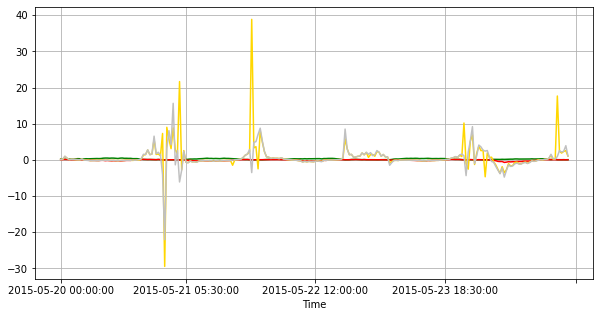

In [152]:
date_start = "2015-05-20"
date_end = "2015-05-25"
fix, ax = plt.subplots(figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
combined_cabauw.loc[date_start:date_end, "friction_velocity:surface:m_s-1_pred"].plot(color="green")

combined_cabauw.loc[date_start:date_end, "temperature_scale:surface:K_pred"].plot(color="red")
(10 / combined_cabauw.loc[date_start:date_end, "obukhov_length:surface:m"]).plot(color='gold', label="Obukhov")
zeta.loc[date_start:date_end].plot(color="silver")
plt.grid()
#plt.ylim(-0.5, 0.5)